In [5]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from ipywidgets import interact
from skimage.transform import resize
from fastai import *
from fastai.vision.all import *

import sys
# import band plotter
sys.path.append('..')
from src.band_plotters import plot, DATA_DIRECTORY, plot_from_bands_picture, plot_from_bands_tensor
from src.Tiff32Image import Tiff32Image

## Constants and Selected Values

In [6]:
NUMBER_OF_NEAR_BANDS = 12 
RERUN = True

MIN_NUMBER_OF_BANDS = 12
MAX_WIDTH =  126

MAX_ENERGY_MINUS_EFERMI =  20 # actually 30 but only 1 material exceeds 20
MIN_ENERGY_MINUS_EFERMI =  -17 # actually -100 but only 2 materials exceed -22

# Used for images
SELECTED_WIDTH = 128

## Function to get N Closest Bands

In [7]:
def get_closest_n_bands(bands_dict, n=NUMBER_OF_NEAR_BANDS, average=True): # at the gamma point, or average if average=True
    
    
    energy_minus_efermi = np.array(bands_dict["bands"]["1"]) - bands_dict["efermi"]
    distance_from_efermi = np.abs(energy_minus_efermi)
    
    if average:
        distance_from_efermi = np.mean(distance_from_efermi, axis=1)
    else:
        distance_from_efermi = distance_from_efermi[:, 0]
    
    if len(distance_from_efermi) == n:
        return energy_minus_efermi
    
    idx = np.argpartition(distance_from_efermi, n)
    idx = np.sort(idx[:n])
    return energy_minus_efermi[idx]

In [8]:
#quick test
example_material_id = "2dm-100"
example = DATA_DIRECTORY/f"bands/{example_material_id}.json"
bands_dict=json.load(open(example))
energy_minus_efermi = np.array(bands_dict["bands"]["1"]) - bands_dict["efermi"]

# print(energy_minus_efermi[9:12])
print("avg distances from efermi")
print(dict(enumerate(np.average(energy_minus_efermi, 1))))

expected = energy_minus_efermi[40:43]
actual = get_closest_n_bands(bands_dict, 3)

assert((actual==expected).all())

avg distances from efermi
{0: -34.08991558666668, 1: -34.08991439619048, 2: -34.001131062857134, 3: -34.00109058666666, 4: -33.750671539047616, 5: -33.75059415809523, 6: -15.128167967619046, 7: -15.011742967619046, 8: -14.375142967619048, 9: -14.307662015238092, 10: -13.40850130095238, 11: -13.076832253333334, 12: -12.208931062857143, 13: -12.141408443809524, 14: -11.58915130095238, 15: -11.313389396190477, 16: -6.01067630095238, 17: -5.820348920000001, 18: -5.360045348571428, 19: -5.263369158095237, 20: -4.96832392, 21: -4.821562015238095, 22: -4.218819158095238, 23: -4.172496539047619, 24: -3.8016167771428564, 25: -3.598367967619047, 26: -3.32992392, 27: -3.224037015238094, 28: -2.8461632057142854, 29: -2.6967024914285713, 30: -2.4146834438095235, 31: -2.3495548723809523, 32: -2.1641334438095234, 33: -2.06747511047619, 34: -1.8494132057142854, 35: -1.8066358247619045, 36: -1.6428239199999997, 37: -1.529084634285714, 38: -1.175676300952381, 39: -0.972084634285714, 40: 0.49979036571428

### Determining Constants for Image Processing

In [ ]:
if RERUN:
    df_template = pd.read_csv("../fingerprints/template.csv", index_col="ID")
    MIN_BANDS = 1000
    MAX_WIDTH = 0

    MAX_ENERGY_MINUS_EFERMI = 0
    MIN_ENERGY_MINUS_EFERMI = 0
    
    
    for i, material_id in enumerate(df_template.index):
        file_name = DATA_DIRECTORY/f"bands/{material_id}.json"
        bands_dict=json.load(open(file_name))
        energy_minus_efermi = np.array(bands_dict["bands"]["1"]) - bands_dict["efermi"]
        try:
            nearest_n_bands = get_closest_n_bands(bands_dict)
        except:
            print("EPIC FAIL", material_id)
        
        if MIN_BANDS > energy_minus_efermi.shape[0]:
            MIN_BANDS = energy_minus_efermi.shape[0]
            print(f"{material_id}: new min height: {MIN_BANDS}")
            
        if MAX_WIDTH < energy_minus_efermi.shape[1]:
            MAX_WIDTH = energy_minus_efermi.shape[1]
            print(f"{material_id}: new max width: {MAX_WIDTH}")

        if MAX_ENERGY_MINUS_EFERMI < nearest_n_bands.max():
            MAX_ENERGY_MINUS_EFERMI = nearest_n_bands.max()
            print(f"{material_id}: new max energy threshold: {MAX_ENERGY_MINUS_EFERMI}")
            
        if MIN_ENERGY_MINUS_EFERMI > nearest_n_bands.min():
            MIN_ENERGY_MINUS_EFERMI = nearest_n_bands.min()
            print(f"{material_id}: new min energy threshold: {MIN_ENERGY_MINUS_EFERMI}")
            
        if i % 200 == 0:
            print(i, "/", len(df_template))
            
        
    print("MIN_BANDS = ", MIN_BANDS)
    print("MAX_WIDTH = ", MAX_WIDTH)

    print("MAX_ENERGY_MINUS_EFERMI = ", MAX_ENERGY_MINUS_EFERMI)
    print("MIN_ENERGY_MINUS_EFERMI = ", MIN_ENERGY_MINUS_EFERMI)

2dm-1: new min height: 32
2dm-1: new max width: 63
2dm-1: new max energy threshold: 8.74126806
2dm-1: new min energy threshold: -7.81243194
0 / 5270
2dm-3: new max width: 84
2dm-4: new max width: 105
2dm-11: new max energy threshold: 9.6577196
2dm-43: new max energy threshold: 18.826386069999998
2dm-49: new min energy threshold: -7.9732636
2dm-124: new min energy threshold: -8.370588999999999
2dm-199: new min energy threshold: -8.57176651
200 / 5270
2dm-243: new min energy threshold: -9.00941145
2dm-247: new min energy threshold: -10.80697224
2dm-383: new min energy threshold: -11.786041619999999
400 / 5270
600 / 5270
800 / 5270
2dm-951: new max energy threshold: 19.248716
2dm-994: new min energy threshold: -13.93925808
1000 / 5270
2dm-1109: new min energy threshold: -16.51780882
1200 / 5270
1400 / 5270
1600 / 5270
1800 / 5270
2000 / 5270
2200 / 5270
2400 / 5270
2600 / 5270
2dm-2990: new min height: 16
2dm-2990: new max energy threshold: 29.62598616
2dm-2990: new min energy threshold: 

## Visualizing Energy Values

In [6]:
def show(x):

    example = DATA_DIRECTORY/f"bands/2dm-{x}.json"
    bands_dict=json.load(open(example))
    bands_minus_efermi = np.array(bands_dict["bands"]["1"]) - bands_dict["efermi"]
    plt.imshow(bands_minus_efermi)
    plt.show()
    bands_minus_efermi_in_threshold = get_closest_n_bands(bands_dict)
    plt.imshow(bands_minus_efermi_in_threshold)

interact(show, x=300)

interactive(children=(IntSlider(value=300, description='x', max=900, min=-300), Output()), _dom_classes=('widg…

<function __main__.show(x)>

## Plotting nearest bands

In [7]:
def show_plots(x):
    example = DATA_DIRECTORY/f"bands/2dm-{x}.json"
    bands_dict=json.load(open(example))
    selected_band_energies_minus_efermi = get_closest_n_bands(bands_dict)
    plot(f"2dm-{x}", dos=False)
    plot_from_bands_picture(f"2dm-{x}", selected_band_energies_minus_efermi, e_bounds=[-4, +4])
    
interact(show_plots, x=1000)

interactive(children=(IntSlider(value=1000, description='x', max=3000, min=-1000), Output()), _dom_classes=('w…

<function __main__.show_plots(x)>

Resizing seems to be fine - now we need to save the images as PNGs and check they can be loaded properly.

## Saving Example as Image and Checking it can be Loaded

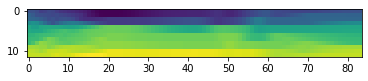

In [8]:
example_material_id = "2dm-100"
example = DATA_DIRECTORY/f"bands/{example_material_id}.json"
bands_dict=json.load(open(example))
selected_energies_minus_efermi = get_closest_n_bands(bands_dict)

plt.imshow(selected_energies_minus_efermi)

(29058, 23217)

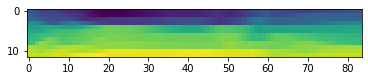

In [9]:
energies_int = (2**16-1) * (selected_energies_minus_efermi - MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI) / (MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI - MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI)
energies_int = energies_int.astype(np.uint16)
plt.imshow(energies_int)
energies_int.max(), energies_int.min()

In [10]:
from skimage import io
energies_int = energies_int.astype(np.uint16)
io.imsave('output.tiff', energies_int)

array([[24671, 24662, 24562, ..., 24661, 24668, 24671],
       [25059, 24898, 24640, ..., 25060, 25059, 25059],
       [25155, 25130, 25057, ..., 25155, 25155, 25155],
       ...,
       [28252, 28239, 28196, ..., 28249, 28252, 28252],
       [28447, 28423, 28356, ..., 28439, 28445, 28447],
       [28512, 28512, 28514, ..., 28512, 28512, 28512]], dtype=uint16)

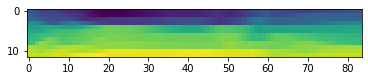

In [11]:
# test it can be loaded load
loaded = io.imread("output.tiff", np.uint16)
assert((loaded == energies_int).all())
plt.imshow(loaded)
loaded

In [12]:
datablock = DataBlock(
    blocks=(ImageBlock(cls=Tiff32Image), ImageBlock(cls=Tiff32Image)), 
    get_items=get_image_files,
    n_inp=1,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    batch_tfms=[IntToFloatTensor(div=2**16-1),],
    item_tfms=Resize((12, 128))
        )

dls = datablock.dataloaders(".", bs=1)
dls.show_batch()

In [13]:
xb, yb = dls.one_batch()
xb.shape

torch.Size([1, 1, 12, 128])

Dimensions of energy array don't match those of 2dm-100: resizing.


<AxesSubplot:xlabel='Wavevector $k$', ylabel='$E-E_F$ / eV'>

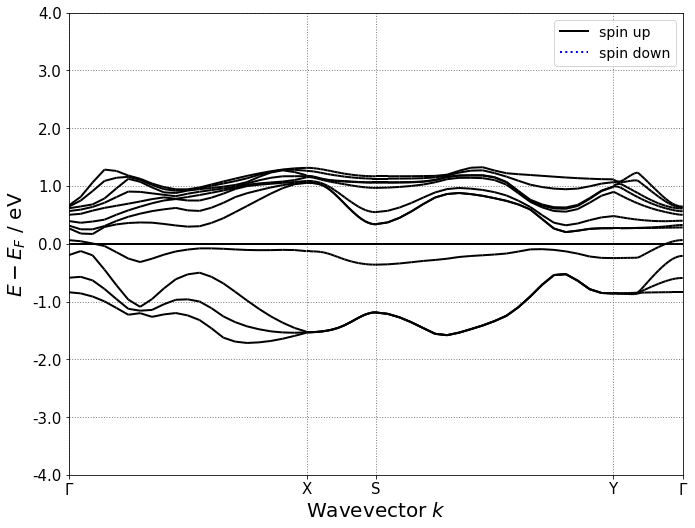

In [14]:
plot_from_bands_tensor(example_material_id, xb[0, 0], e_bounds=[-4, +4])

This plot shows that fastai resizes don't mess things up

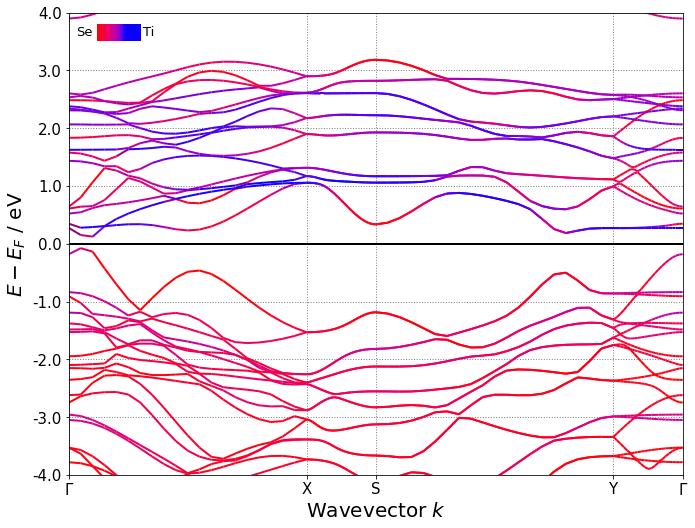

In [15]:
plot(example_material_id, dos=False)

## Saving All Images

In [20]:
df_template = pd.read_csv("../fingerprints/template.csv", index_col="ID")
latest_material_that_already_exists = None

for i, material_id in enumerate(df_template.index):
    input_file_path = DATA_DIRECTORY/f"bands/{material_id}.json"
    output_file_path = DATA_DIRECTORY/f"images/energies_{NUMBER_OF_NEAR_BANDS}_nearest_bands/{material_id}.tiff"
    
    if output_file_path.exists():
        latest_material_that_already_exists = material_id
        continue;
    elif latest_material_that_already_exists:
        print(f"All images up to {latest_material_that_already_exists}.tiff already exist.")
        latest_material_that_already_exists = None
        
        
    
    bands_dict=json.load(open(input_file_path))
    energy_minus_efermi_in_threshold = get_closest_n_bands(bands_dict)
    energy_minus_efermi_in_threshold[energy_minus_efermi_in_threshold > MAX_ENERGY_MINUS_EFERMI] = MAX_ENERGY_MINUS_EFERMI
    energy_minus_efermi_in_threshold[energy_minus_efermi_in_threshold < MIN_ENERGY_MINUS_EFERMI] = MIN_ENERGY_MINUS_EFERMI
    
    image_int = (2**16-1) * (energy_minus_efermi_in_threshold - MIN_ENERGY_MINUS_EFERMI) / (MAX_ENERGY_MINUS_EFERMI - MIN_ENERGY_MINUS_EFERMI)
    image_int = image_int.astype(np.uint16)
    io.imsave(output_file_path, image_int)
    
    if i % 200 == 0:
        print(i, "/", len(df_template))

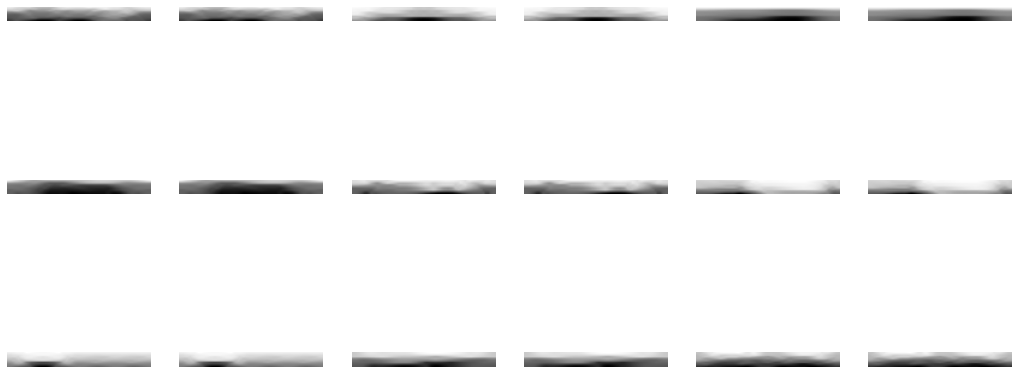

In [21]:
dls = DataBlock(
    blocks=(ImageBlock(cls=Tiff32Image), ImageBlock(cls=Tiff32Image)), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    item_tfms=[Resize((12, 120, ResizeMethod.Pad))],
    batch_tfms=[IntToFloatTensor(div=2**16-1),],
        ).dataloaders(DATA_DIRECTORY/f"images/energies_{NUMBER_OF_NEAR_BANDS}_nearest_bands", bs=32)

dls.show_batch()